## **1. Import Required Libraries**

<hr style="border: 1px solid red;">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
sns.set_theme(style="whitegrid")

<hr style="border: 1px solid red;">

## **2. Mount Google Drive and Load Data**

<hr style="border: 1px solid red;">


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***

In [3]:
import os
supply_chain_path = '/content/drive/My Drive/supply_chain'
print(os.listdir(supply_chain_path))

['DescriptionDataCoSupplyChain.csv', 'tokenized_access_logs.csv', 'DataCoSupplyChainDataset.csv', 'supply_chain_data_cleaned.csv']


***

In [4]:
df = pd.read_csv('/content/drive/My Drive/supply_chain/supply_chain_data_cleaned.csv', encoding='latin-1')

<hr style="border: 1px solid red;">

## **3. Customer Purchase Data Aggregation**
***
Aggregate orders and sales at the customer level to compute metrics needed for segmentation and behavior analysis.
***
<hr style="border: 1px solid red;">

In [7]:
# Convert 'Last Purchase' column to datetime
customer_summary['Last Purchase'] = pd.to_datetime(customer_summary['Last Purchase'], errors='coerce')

# Now calculate Recency safely
customer_summary['Recency'] = (current_date - customer_summary['Last Purchase']).dt.days

# Aggregate customer purchase history
customer_summary = df.groupby('Customer Id').agg({
    'order date (DateOrders)': ['min', 'max'],
    'Order Id': 'nunique',
    'Sales': 'sum'
})

# Flatten columns
customer_summary.columns = ['First Purchase', 'Last Purchase', 'Total Orders', 'Total Sales']

# Calculate Recency, Frequency, Monetary values
current_date = df['order date (DateOrders)'].max() + pd.Timedelta(days=1)
customer_summary['Recency'] = (current_date - customer_summary['Last Purchase']).dt.days
customer_summary['Frequency'] = customer_summary['Total Orders']
customer_summary['Monetary'] = customer_summary['Total Sales']

customer_summary = customer_summary.reset_index()
customer_summary.head()

,Customer Id,First Purchase,Last Purchase,Total Orders,Total Sales,Recency,Frequency,Monetary
0,1,2015-12-01 22:18:00,2015-12-01 22:18:00,1,499.950012,793,1,499.950012
1,2,2015-08-10 18:05:00,2017-09-17 15:04:00,4,1819.730034,137,4,1819.730034
2,3,2015-12-12 09:30:00,2017-06-16 01:22:00,5,3537.680094,230,5,3537.680094
3,4,2015-05-12 16:48:00,2017-01-16 18:13:00,4,1719.630030,381,4,1719.630030
4,5,2016-06-16 09:24:00,2016-10-31 00:38:00,3,1274.750023,458,3,1274.750023


<hr style="border: 1px solid red;">

## **4. RFM Scoring and Customer Segmentation**
***
Assign scores for Recency, Frequency, and Monetary value by binning each into quartiles. Combine scores to form overall customer segments.
***
<hr style="border: 1px solid red;">

In [8]:
# Define RFM quartile scoring functions
def r_score(x, r_quartiles):
    if x <= r_quartiles[0.25]:
        return 4
    elif x <= r_quartiles[0.50]:
        return 3
    elif x <= r_quartiles[0.75]:
        return 2
    else:
        return 1

def fm_score(x, fm_quartiles):
    if x <= fm_quartiles[0.25]:
        return 1
    elif x <= fm_quartiles[0.50]:
        return 2
    elif x <= fm_quartiles[0.75]:
        return 3
    else:
        return 4

# Calculate quartiles
r_quartiles = customer_summary['Recency'].quantile([0.25, 0.5, 0.75]).to_dict()
f_quartiles = customer_summary['Frequency'].quantile([0.25, 0.5, 0.75]).to_dict()
m_quartiles = customer_summary['Monetary'].quantile([0.25, 0.5, 0.75]).to_dict()

# Assign scores
customer_summary['R_Score'] = customer_summary['Recency'].apply(r_score, r_quartiles=r_quartiles)
customer_summary['F_Score'] = customer_summary['Frequency'].apply(fm_score, fm_quartiles=f_quartiles)
customer_summary['M_Score'] = customer_summary['Monetary'].apply(fm_score, fm_quartiles=m_quartiles)

# Combine scores
customer_summary['RFM_Score'] = customer_summary['R_Score'].map(str) + \
                                customer_summary['F_Score'].map(str) + \
                                customer_summary['M_Score'].map(str)

# Display sample segments
customer_summary.head()

,Customer Id,First Purchase,Last Purchase,Total Orders,Total Sales,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1,2015-12-01 22:18:00,2015-12-01 22:18:00,1,499.950012,793,1,499.950012,1,1,2,112
1,2,2015-08-10 18:05:00,2017-09-17 15:04:00,4,1819.730034,137,4,1819.730034,3,3,3,333
2,3,2015-12-12 09:30:00,2017-06-16 01:22:00,5,3537.680094,230,5,3537.680094,2,3,4,234
3,4,2015-05-12 16:48:00,2017-01-16 18:13:00,4,1719.630030,381,4,1719.630030,1,3,3,133
4,5,2016-06-16 09:24:00,2016-10-31 00:38:00,3,1274.750023,458,3,1274.750023,1,2,2,122


## **5. Visualize RFM distributions and segments**
***
Plot distributions for Recency, Frequency, and Monetary scores and explore segment counts.
***
<hr style="border: 1px solid red;">

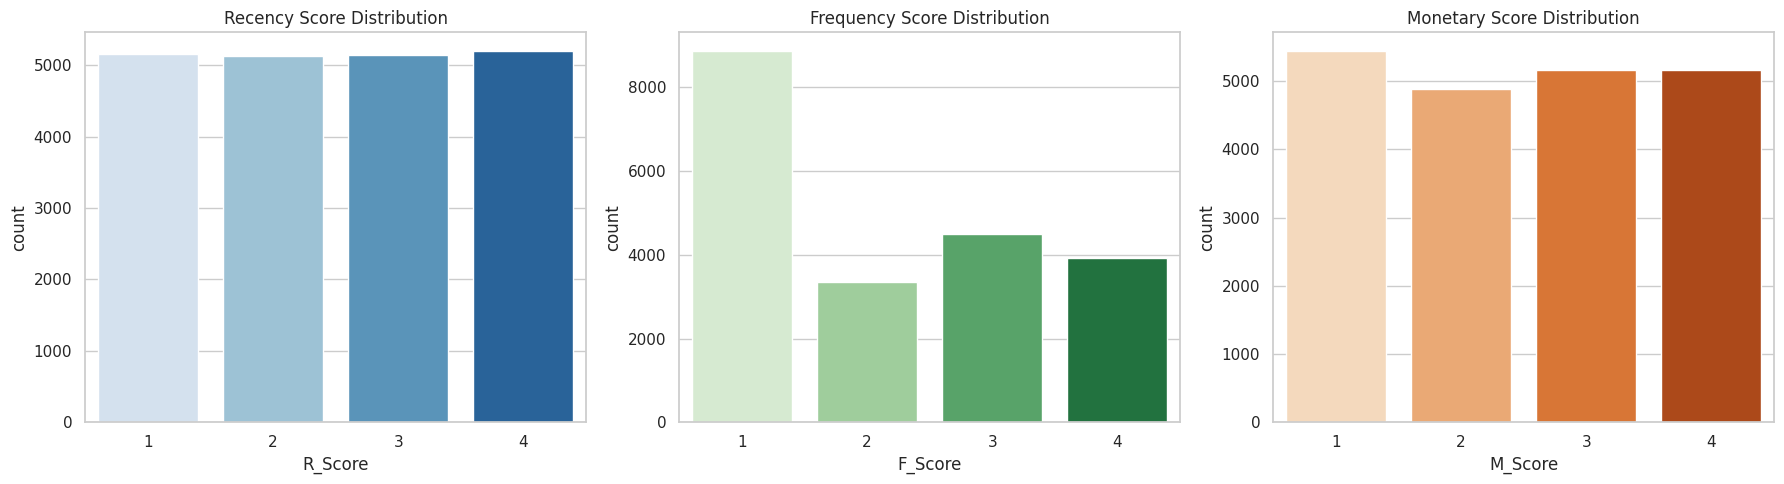

RFM_Score
111     106
112     351
113       1
121      11
122    1024
123     906
124      35
132     104
133    1056
134     595
142       4
143     144
144     821
211      15
212      73
213       2
221       4
222     464
223     556
224      19
232     108
233    1109
234     787
242       1
243     250
244    1744
311    1173
312    1599
313     352
321       1
322     131
323     190
324      10
332      43
333     386
334     308
343     116
344     841
411    4132
412     977
413      92
Name: count, dtype: int64


In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='R_Score', data=customer_summary, ax=axs[0], palette='Blues')
axs[0].set_title('Recency Score Distribution')

sns.countplot(x='F_Score', data=customer_summary, ax=axs[1], palette='Greens')
axs[1].set_title('Frequency Score Distribution')

sns.countplot(x='M_Score', data=customer_summary, ax=axs[2], palette='Oranges')
axs[2].set_title('Monetary Score Distribution')

plt.tight_layout()
plt.show()

# Segment sizes
segment_counts = customer_summary['RFM_Score'].value_counts().sort_index()
print(segment_counts)

<hr style="border: 1px solid red;">

## **6. Flag valuable customers and those at risk based on RFM Scores.**
***
Define customers with highest R, F, M scores as "Best Customers", those with low R but high M as "At-Risk", etc.
***
<hr style="border: 1px solid red;">

In [10]:
def rfm_segment(df):
    if df['R_Score'] >= 3 and df['F_Score'] >= 3 and df['M_Score'] >= 3:
        return 'Best Customers'
    elif df['R_Score'] == 1:
        return 'At Risk'
    elif df['R_Score'] <= 2 and df['F_Score'] >= 3:
        return 'Loyal Customers'
    elif df['R_Score'] >= 3 and df['F_Score'] <= 2:
        return 'Potential Loyalist'
    else:
        return 'Others'

customer_summary['Segment'] = customer_summary.apply(rfm_segment, axis=1)

# Show segment counts
customer_summary['Segment'].value_counts()

,count
Segment,
Potential Loyalist,8657
At Risk,5158
Loyal Customers,3999
Best Customers,1651
Others,1176


<hr style="border: 1px solid red;">

## **7. Visualize Counts of Customer Segments**
***
Bar plot showing the distribution of customer segments as defined.
***
<hr style="border: 1px solid red;">

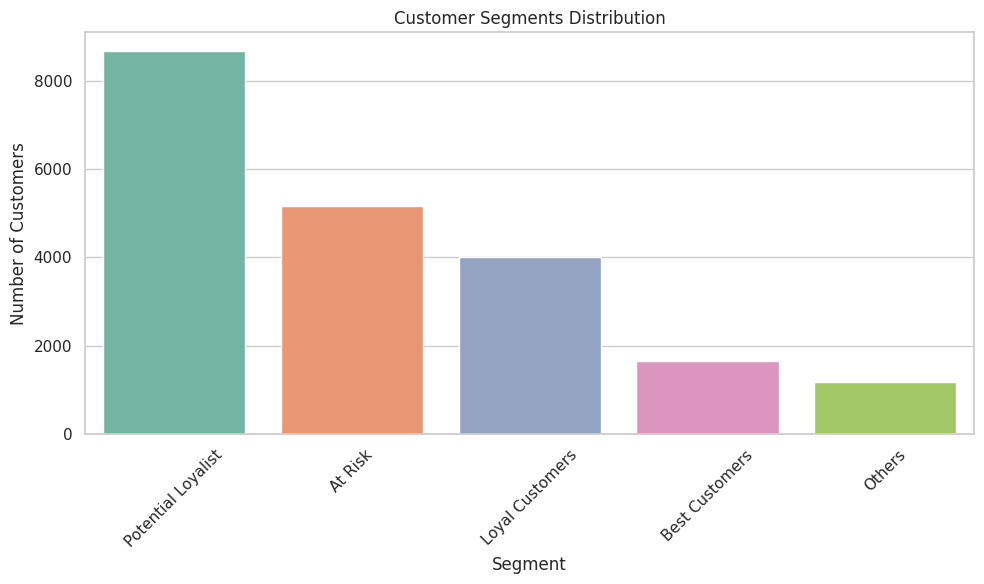

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(data=customer_summary, x='Segment', order=customer_summary['Segment'].value_counts().index, palette='Set2')
plt.title('Customer Segments Distribution')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<hr/>
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
  <ul>
    <li><strong>What it shows:</strong> The breakdown of customers across all possible RFM score combinations (e.g., "111", "224", "344", etc.), where each digit represents Recency, Frequency, and Monetary score respectively (from 1=lowest to 4=highest).</li>
    <li><strong>Interpretation:</strong> Most customers are concentrated in mid-to-high RFM score combinations—especially in groups like "411" (4,132 customers), "312" (1,599), "244" (1,744), and "233" (1,109). Higher RFM scores correspond to customers who purchase often, spend more, and buy more recently, highlighting strong retention and high-value segments. The diversity of RFM profiles suggests the business has a mix of loyal, valuable customers and segments that could benefit from targeted engagement.</li>
  </ul>
</div>
<hr/>
<hr style="border: 1px solid red;">

## **8. Calculate basic Customer Lifetime Value (CLV) proxies and provide recommendations for marketing focus.**
***
CLV can be approximated by total sales and purchase frequency.
***
<hr style="border: 1px solid red;">

In [12]:
# CLV proxy = Average order value * total orders (using Monetary and Frequency)
customer_summary['CLV'] = customer_summary['Monetary'] / customer_summary['Frequency'] * customer_summary['Frequency']

# Top CLV customers
top_clv = customer_summary.sort_values('CLV', ascending=False).head(10)
print(top_clv[['Customer Id', 'CLV', 'Segment']])

      Customer Id           CLV          Segment
782           791  10524.170178   Best Customers
9295         9371   9299.030207   Best Customers
8694         8766   9296.140186   Best Customers
1636         1657   9223.710152  Loyal Customers
2612         2641   9130.920224  Loyal Customers
1271         1288   9019.110199  Loyal Customers
3672         3710   9019.100208  Loyal Customers
4209         4249   8918.850134  Loyal Customers
5603         5654   8904.950211   Best Customers
5573         5624   8761.980183   Best Customers


<hr/>
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
  <strong>High-Value Customers (CLV Analysis)(CLV)</strong>
  <ul>
    <li><strong>What it shows:</strong> The top customers by calculated Customer Lifetime Value (CLV) along with their behavioral segments (Best Customers, Loyal Customers).</li>
    <li><strong>Interpretation:</strong> The highest-CLV customers are found in both "Best Customers" and "Loyal Customers" segments, with CLVs ranging from over 8,700 to above 10,500. These are the most profitable and engaged individuals to the business—worth prioritizing in loyalty and personalized marketing programs for maximum retention and growth.</li>
  </ul>
</div>
<hr/>
<hr style="border: 1px solid red;">

## **9. Customer Segment Recommendations and Actionable Insights**
<hr style="border: 1px solid red;">


In [13]:
# Recommendations implementation based on customer segments and CLV

# Define marketing actions based on segment categories
def customer_recommendations(segment):
    if segment == 'Best Customers':
        return 'Focus retention efforts with loyalty programs and personalized offers.'
    elif segment == 'At Risk':
        return 'Engage with reactivation campaigns and targeted incentives.'
    elif segment == 'Loyal Customers':
        return 'Leverage for referral programs and upselling opportunities.'
    else:
        return 'Tailor marketing, inventory, and service strategies to meet segment needs.'

# Apply the recommendations to customer summary dataframe
customer_summary['Recommendation'] = customer_summary['Segment'].apply(customer_recommendations)

# Display sample of customers with recommendations
print(customer_summary[['Customer Id', 'Segment', 'CLV', 'Recommendation']].head(10))

   Customer Id          Segment          CLV  \
0            1          At Risk   499.950012   
1            2   Best Customers  1819.730034   
2            3  Loyal Customers  3537.680094   
3            4          At Risk  1719.630030   
4            5          At Risk  1274.750023   
5            6          At Risk  3259.510025   
6            7  Loyal Customers  5569.480106   
7            8   Best Customers  3763.500042   
8            9   Best Customers  3229.680056   
9           10           Others  1264.790012   

                                      Recommendation  
0  Engage with reactivation campaigns and targete...  
1  Focus retention efforts with loyalty programs ...  
2  Leverage for referral programs and upselling o...  
3  Engage with reactivation campaigns and targete...  
4  Engage with reactivation campaigns and targete...  
5  Engage with reactivation campaigns and targete...  
6  Leverage for referral programs and upselling o...  
7  Focus retention efforts with

<hr/>
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
  <strong>Customer Segment Recommendations and Actionable Insights</strong>
  <ul>
    <li><strong>What it shows:</strong> Example customers with their segment tags, calculated CLV, and automated strategic recommendations.</li>
    <li><strong>Interpretation:</strong>
      <ul>
        <li><strong>Best Customers:</strong> Receive loyalty and retention-focused strategies.</li>
        <li><strong>At Risk:</strong> Flagged for reactivation and targeted incentives to win them back.</li>
        <li><strong>Loyal Customers:</strong> Prime targets for referral programs and upselling.</li>
        <li><strong>Others:</strong> Guided toward more tailored outreach and service improvements.</li>
      </ul>
    </li>
    <li><strong>Actionable takeaway:</strong> By aligning marketing and service tactics to these segments, the business can increase retention, reactivate at-risk customers, and maximize returns from the most lucrative individuals.</li>
  </ul>
</div>
<hr/>
<hr style="border: 1px solid red;">